<a href="https://colab.research.google.com/github/ye2x/ML_project/blob/main/Binary%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ini adalah fungsi untuk melakukan import library yang digunakan

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

Ran the import statements.


In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

In [3]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most 
# Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
8277,0.6,-0.7,-0.8,0.0,0.6,0.6,0.6,-0.7,0.2
9072,0.3,-0.1,1.5,-0.3,-0.5,-0.6,-0.5,-0.2,-1.1
13579,-1.2,0.8,-0.8,-0.2,-0.2,-0.4,-0.2,0.4,0.4
5723,0.7,-0.7,1.2,-0.4,-0.4,-0.3,-0.4,-0.7,-0.4
8444,0.5,-0.7,0.5,-0.3,-0.5,-0.4,-0.5,0.5,0.4


In [4]:
# Calculate the Z-scores of each column in the test set and
# write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

In [5]:
threshold = 265000
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float) 
train_df_norm["median_house_value_is_high"].head(8000)

8277    0.0
9072    0.0
13579   0.0
5723    0.0
8444    0.0
         ..
4704    0.0
15648   0.0
15601   0.0
6332    0.0
10966   0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

In [6]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Create a numerical feature column to represent median_income.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Create a numerical feature column to represent total_rooms.
tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(train_df_norm))

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[-0.68095994,  0.03914572],
       [-0.16360193, -0.33746892],
       [ 0.41879264, -0.21544762],
       ...,
       [ 0.14523017, -0.01177295],
       [-0.5023582 , -0.49710584],
       [ 2.6789846 ,  0.80659556]], dtype=float32)>

In [7]:
#@title Define the functions that create and train a model.
def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

print("Defined the create_model and train_model functions.")   

Defined the create_model and train_model functions.


In [8]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


Epoch 1/20


170/170 [==============================] - 1s 3ms/step - loss: 0.9869 - accuracy: 0.2049
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.8862 - accuracy: 0.2215
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.7976 - accuracy: 0.2542
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.7202 - accuracy: 0.3235
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6546 - accuracy: 0.4945
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6007 - accuracy: 0.6753
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5557 - accuracy: 0.7285
Epoch 8/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5192 - accuracy: 0.7686
Epoch 9/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4895 - accuracy: 0.8065
Epoch 10/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4653 - accuracy: 0.8216
Epoch 11/2

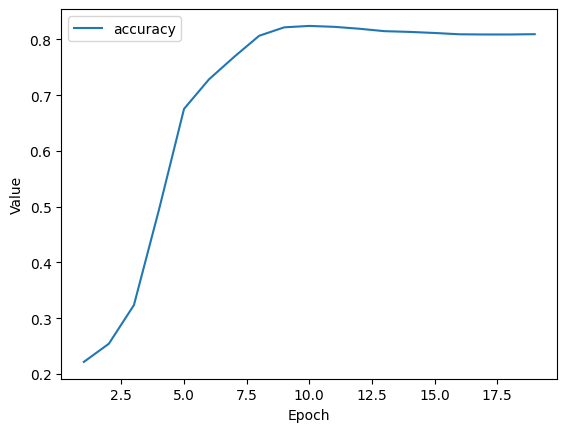

In [9]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

In [10]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

30/30 [==============================] - 0s 2ms/step - loss: 0.4067 - accuracy: 0.8003


[0.40674418210983276, 0.8003333210945129]

Epoch 1/20


170/170 [==============================] - 2s 2ms/step - loss: 0.5870 - accuracy: 0.6024 - precision: 0.3752 - recall: 0.8889
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5376 - accuracy: 0.6447 - precision: 0.4018 - recall: 0.8632
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4962 - accuracy: 0.6811 - precision: 0.4285 - recall: 0.8279
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4627 - accuracy: 0.7149 - precision: 0.4589 - recall: 0.7883
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4378 - accuracy: 0.7424 - precision: 0.4898 - recall: 0.7490
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4195 - accuracy: 0.7621 - precision: 0.5174 - recall: 0.7097
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4082 - accuracy: 0.7819 - precision: 0.5515 - recall: 0.6807
Epoch 8/20
170/170 [==============================] 

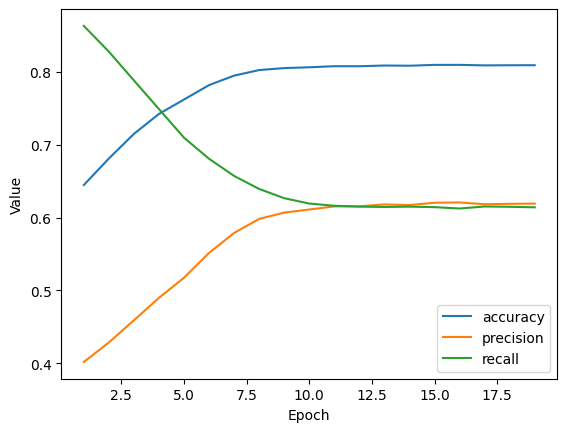

In [11]:
#@title Double-click to view the solution for Task 3.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.35
label_name = "median_house_value_is_high"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)


# The new graphs suggest that precision and recall are 
# somewhat in conflict. That is, improvements to one of
# those metrics may hurt the other metric.

Epoch 1/20


170/170 [==============================] - 1s 2ms/step - loss: 0.6483 - accuracy: 0.7211 - precision: 0.4351 - recall: 0.3902
Epoch 2/20
170/170 [==============================] - 1s 4ms/step - loss: 0.5817 - accuracy: 0.7819 - precision: 0.5915 - recall: 0.4109
Epoch 3/20
170/170 [==============================] - 1s 5ms/step - loss: 0.5280 - accuracy: 0.8101 - precision: 0.7020 - recall: 0.4165
Epoch 4/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4866 - accuracy: 0.8244 - precision: 0.7742 - recall: 0.4191
Epoch 5/20
170/170 [==============================] - 1s 5ms/step - loss: 0.4552 - accuracy: 0.8289 - precision: 0.7987 - recall: 0.4212
Epoch 6/20
170/170 [==============================] - 1s 5ms/step - loss: 0.4333 - accuracy: 0.8313 - precision: 0.8147 - recall: 0.4203
Epoch 7/20
170/170 [==============================] - 1s 6ms/step - loss: 0.4186 - accuracy: 0.8334 - precision: 0.8214 - recall: 0.4257
Epoch 8/20
170/170 [==============================] 

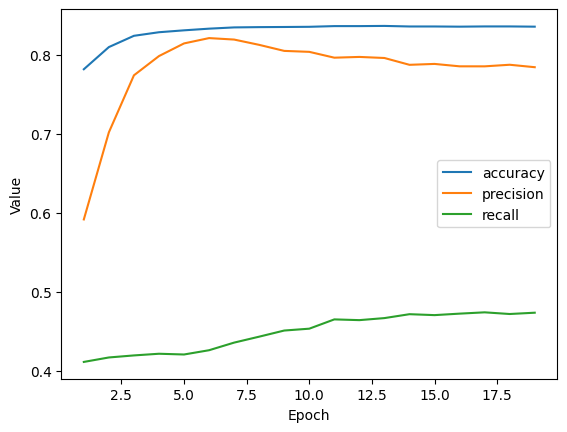

In [12]:
#@title Double-click to view the solution for Task 4.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52
label_name = "median_house_value_is_high"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

# A `classification_threshold` of slightly over 0.5
# appears to produce the highest accuracy (about 83%).
# Raising the `classification_threshold` to 0.9 drops 
# accuracy by about 5%.  Lowering the 
# `classification_threshold` to 0.3 drops accuracy by 
# about 3%. 

Epoch 1/20


170/170 [==============================] - 1s 2ms/step - loss: 0.8735 - auc: 0.1970
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.7603 - auc: 0.1950
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6678 - auc: 0.1977
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5952 - auc: 0.4296
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5412 - auc: 0.7948
Epoch 6/20
170/170 [==============================] - 1s 5ms/step - loss: 0.5016 - auc: 0.8190
Epoch 7/20
170/170 [==============================] - 1s 3ms/step - loss: 0.4721 - auc: 0.8276
Epoch 8/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4502 - auc: 0.8307
Epoch 9/20
170/170 [==============================] - 0s 3ms/step - loss: 0.4333 - auc: 0.8337
Epoch 10/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4210 - auc: 0.8350
Epoch 11/20
170/170 [==============================] - 0s 2m

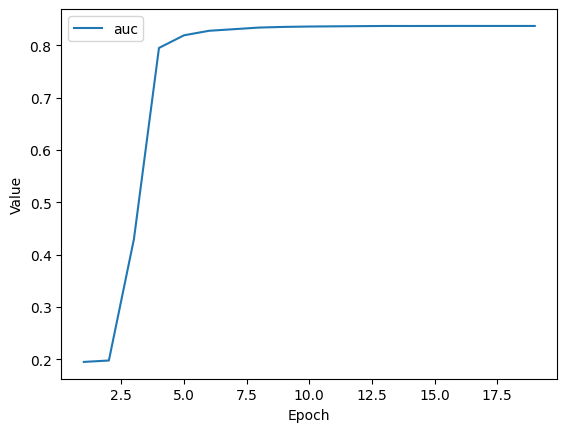

In [13]:
#@title Double-click to view the solution for Task 5.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# AUC is a reasonable "summary" metric for 
# classification models.
# Here is the updated definition of METRICS to 
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)